# Predicting no. of Bikes Rented

Many American cities, including Washington, D.C., have communal bicycle sharing stations, where bikes can be rented. The district collects data on the no. of bikes rented by people, by hour and day. 

This data was compiled into a csv file which is available [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

The descriptions for some of the columns are given as follows:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

We'll use the information from the dataset to try and predict the total number of bikes that will be rented by people in a given hour. 

The `cnt` column is therefore the column we'll be trying to predict, and all the other columns, with the exception of the `casual` and `registered` columns, will be used as predictive variables. 

Various algorithms will be used like Linear Regression, Decision Tree Regression, and Random Forest Regression, to see which fares the best and returns the lowest error.

## Introduction

We'll start by reading in the dataset, and briefly exploring it.

In [1]:
import numpy as np
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')

bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


It would be helpful to first get a picture of the distribution of the total rentals. 

We'll do this by making a histogram of the `cnt` column.

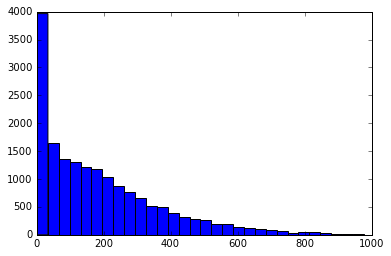

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals['cnt'], bins = 30)

plt.show()

We observe above that the amount of bike rentals each hour is heavily concentrated to the left of the < 50 region. In general, while the majority of hours see fewer than 200 bike rentals, there are some hours where the no. of bikes rented was upwards of 800-900.

We'll next use the `corr` method on the `bike_rentals` dataframe to see how each column correlates with cnt.

In [3]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

From the above correlation table, we see that apart from the `casual` and `registered` column, many other columns have notable correlations with the `cnt` column.

Because a machine will treat each hour differently, without understanding that they are related, we'll add a new column with the following labels to represent hours that are close to each other:

1. `morning`
2. `afternoon`
3. `evening`
4. `night`

This will bundle similar periods of time together, making the model better able to make predictive decisions. 

We'll write a function, `assign_label`, that builds this new column based on the values in the `hr` column.

In [4]:
def assign_label(hour):
    if 6 < hour <= 12:
        return 1 # Morning
    if 12 < hour <= 18:
        return 2 # Afternoon
    if 18 < hour <= 24:
        return 3 # Evening
    if 0 <= hour <= 6:
        return 4 # Night
    

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

bike_rentals.head(3)    

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4


## Selecting an Error Metric

Because the values in the `cnt` column are continuous and numeric, we'll choose to use the mean squared error metric, as it's suitable for handling our data. 

We'll also assign 80% of the rows in `bike_rentals` to the training set, and the rest to the test set. 

### Dividing `bike_rentals` dataset into train and test sets

In [5]:
train = bike_rentals.sample(frac=0.8)

test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Applying Linear Regression

Becaus several columns are highly correlated with the `cnt` target column, it is likely that Linear regression will work decently well on this data. 

In [11]:
column_names = bike_rentals.columns.tolist()

# Removing columns we don't want as features
column_names.remove("cnt")
column_names.remove("registered")
column_names.remove("casual")
column_names.remove("dteday") # time_label column already represents this

features = column_names

features

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

With the list of features prepared, we'll proceed with the linear regression:

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Instantiating the model
lr = LinearRegression()

# Training the model
lr.fit(train[features], train['cnt'])

# Testing the model
predictions = lr.predict(test[features])

# Measuring Accuracy
mse = mean_squared_error(test['cnt'], predictions)

print("The mean squared error using Linear Regression is: ", mse)

The mean squared error using Linear Regression is:  15936.855893358


We notice that the error is extremely high. It is likely that Linear Regression is not a good predictive algorithm for this dataset. 

This might be due to the fact that there are a few very high rental counts, since larger errors are penalized more substantially than lower errors using Mean Squared Error. 

We'll try using a different algorithm this time - Decision Tree Regression.

### Applying Decision Tree Regression

In [27]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_mse = {}

for leafs in range(1,15):

    reg = DecisionTreeRegressor(min_samples_leaf=leafs)

    reg.fit(train[features], train['cnt'])

    predictions = reg.predict(test[features])

    mse = mean_squared_error(test['cnt'], predictions)
    
    decision_tree_mse[leafs] = mse

for each in decision_tree_mse:
    print("MSE using", each, "minimum leafs:", decision_tree_mse[each])

MSE using 1 minimum leafs: 3184.038262370541
MSE using 2 minimum leafs: 2665.8741928781483
MSE using 3 minimum leafs: 2731.7538487725355
MSE using 4 minimum leafs: 2569.7147269697102
MSE using 5 minimum leafs: 2647.0783878584543
MSE using 6 minimum leafs: 2602.7287693795456
MSE using 7 minimum leafs: 2565.778716180393
MSE using 8 minimum leafs: 2571.071618188759
MSE using 9 minimum leafs: 2643.5372367273685
MSE using 10 minimum leafs: 2668.4404077467534
MSE using 11 minimum leafs: 2704.3913061045296
MSE using 12 minimum leafs: 2717.635787326857
MSE using 13 minimum leafs: 2792.583144826344
MSE using 14 minimum leafs: 2812.129508529912


The decision tree regressor appears to have a vastly higher accuracy. The error seems to be minimized by setting the `min_samples_leaf` parameter to a figure from 6 to 8. The lowest MSE we observe is around 2566, when 7 minimum leafs are used.

This is likely because it takes into account the features that are non-linear, such as `season` and the `time_label` column we created.

Next, we'll use the random forest algorithm, which further improves on the decision tree algorithm.

### Applying Random Forest Algorithm

In [51]:
from sklearn.ensemble import RandomForestRegressor

# The following dataframe will store mse values at various settings of
# the min_samples_leaf and max_depth parameters.

random_forest_mse = pd.DataFrame()

for leafs in range(1,8):
    
    mse_list = []
    
    for depth in range(10,30):
        
        # Instantiating
        reg = RandomForestRegressor(min_samples_leaf = leafs, max_depth=depth)

        # Training
        reg.fit(train[features], train['cnt'])

        # Predicting
        predictions = reg.predict(test[features])

        # Computing Error
        mse = mean_squared_error(test['cnt'], predictions)
        mse_list.append(mse)         

        #print("Min leafs:", leafs, ", Depth:", depth, "MSE: ", mse)

    random_forest_mse[leafs] = pd.Series(mse_list)


Min leafs: 1 , Depth: 10 MSE:  2408.7163832972974
Min leafs: 1 , Depth: 11 MSE:  2176.2176743026353
Min leafs: 1 , Depth: 12 MSE:  1922.872973850867
Min leafs: 1 , Depth: 13 MSE:  1872.7617253383537
Min leafs: 1 , Depth: 14 MSE:  1829.7853541683025
Min leafs: 1 , Depth: 15 MSE:  1845.8661256832354
Min leafs: 1 , Depth: 16 MSE:  1740.1259816432569
Min leafs: 1 , Depth: 17 MSE:  1783.1994180860972
Min leafs: 1 , Depth: 18 MSE:  1729.582026023861
Min leafs: 1 , Depth: 19 MSE:  1798.1050989667326
Min leafs: 1 , Depth: 20 MSE:  1787.2554642089508
Min leafs: 1 , Depth: 21 MSE:  1708.9135871204592
Min leafs: 1 , Depth: 22 MSE:  1833.16419871862
Min leafs: 1 , Depth: 23 MSE:  1741.1530898302408
Min leafs: 1 , Depth: 24 MSE:  1835.3609132396402
Min leafs: 1 , Depth: 25 MSE:  1825.911952167976
Min leafs: 1 , Depth: 26 MSE:  1688.6557371686183
Min leafs: 1 , Depth: 27 MSE:  1874.5198713289753
Min leafs: 1 , Depth: 28 MSE:  1801.4511281211214
Min leafs: 1 , Depth: 29 MSE:  1782.3453786401374
Min l

In [62]:
random_forest_mse.columns.name = "No. of Min Leafs"

random_forest_mse.index = range(10,30)

random_forest_mse.index.name = "Max Depth"

random_forest_mse

No. of Min Leafs,1,2,3,4,5,6,7
Max Depth,,,,,,,
10,2408.716383,2424.141467,2380.328019,2454.894213,2466.955431,2410.133775,2453.156139
11,2176.217674,2018.628542,2076.792110,2114.111904,2102.197382,2043.640417,2141.330562
12,1922.872974,1911.366397,1981.727486,1919.080931,2027.931409,2080.580161,2022.106221
13,1872.761725,1859.814144,1740.620075,1788.706021,1863.310893,1960.533453,1918.237607
14,1829.785354,1777.415149,1820.602043,1831.884426,1937.004956,1957.352547,1984.127776
15,1845.866126,1771.404110,1765.474796,1794.440838,1858.246243,1919.758999,1898.538037
16,1740.125982,1720.949759,1718.082026,1812.992074,1869.133364,1926.146888,1890.579426
17,1783.199418,1731.588854,1702.626265,1829.669240,1793.433356,1845.543639,1907.370248
18,1729.582026,1728.760384,1689.109368,1730.302174,1752.007608,1865.387524,1966.943817


In [64]:
# Determining where the lowest MSE was:

a, b = random_forest_mse.stack().idxmin()
print(random_forest_mse.loc[[a], [b]])

No. of Min Leafs            2
Max Depth                    
24                1661.419416


We see that a relatively low MSE of 1661 is observed when the `min_samples_leaf` parameter is set to 2, and then `max_depth` parameter is set to 24. 

## Conclusion

Using the Random Forest Regressor returned an MSE of only 1661, down from 2566 using the Decision Tree Regressor algorithm, and 15937 using the Linear Regressor algorithm. 

A lot of this improvement is owed to the fact that Random Forests tend to be:
1. Much more accurate than simple models like linear regression, and
2. Tend to overfit much less than Decision Trees. 

To further minimize overfitting, we experimented with tuning parameters like maximum depth, and minimum samples per leaf. In our case, we found that the MSE was minimized using 2 minimum leafs, and a max depth of 24.